# Classiq Challenge Solution

Submitted by team Quantotto

In [2]:
from classiq import *
from classiq.execution import (
    ClassiqBackendPreferences,
    ClassiqSimulatorBackendNames,
    ExecutionPreferences,
)
import numpy as np
import math

In [3]:
def analytical_solution(boundary_condition, x):
    return boundary_condition[0] * np.cos(x) + boundary_condition[1] * np.sin(x)

In [4]:
def norm(a):
    return np.linalg.norm(a)

def normalize(a):
    return list(np.array(a) / norm(a))

def sqrt_sum(a):
    return np.sqrt(np.sum(np.array(a)))

def create_unitary(first_column):
    k = len(first_column)
    added_rows = []
    for i in range(k-1):
        row = [0] * k
        row[i] = 1
        added_rows.append(row)
    A = np.array([
        normalize(first_column),
        *added_rows
    ]).T
    n = A.shape[1]
    # Use Gram-Schmidt orthogonalization
    # Credits: https://www.mycompiler.io/view/Di9dsPfR4gy
    for i in range(1, n):
        for j in range(i):
            A[:, i] = A[:, i] - np.dot(A[:, j], A[:, i]) * A[:, j]
            A[:, i] = A[:, i] / np.linalg.norm(A[:, i])
    return A.tolist()

In [5]:
def calculate_Cs(t, k):
    arr = [((t) ** i) / math.factorial(i) for i in range(k+1)]
    return arr

def calculate_V():
    return [[1, 0], [0, -1]]

def calculate_Vs1(Cs):
    first_col = normalize(np.sqrt(np.array(Cs)).tolist())
    return create_unitary(first_col)

In [6]:
@qfunc
def prep_qubits(Vs1: CArray[CArray[CReal]], approximator: QArray, phi: QBit):
    unitary(Vs1, approximator)

@qfunc
def encode(V: CArray[CReal], Vs1: CArray[CArray[CReal]], ancilla: QBit, approximator: QArray, phi: QBit):
    unitary(V, ancilla)
    control(ctrl=ancilla==0, stmt_block=lambda: prep_qubits(Vs1, approximator, phi))

@qfunc
def approximate(A: CArray[CArray[CReal]], normalized_x0: CArray[CReal], approximator: QNum, phi: QBit):
    inplace_prepare_amplitudes(normalized_x0, bound=0.01, target=phi)
    repeat(2 ** approximator.size, lambda i: control(approximator==i, lambda: power(i, lambda: unitary(A, phi))))


In [7]:
# inputs for y'' + y = 0
x0 = [1.0, 1.0]       # Boundary conditions
A = [[0, 1], [-1, 0]]              # Linear equations (unitary)
k = 7                              # order of approximation
t = np.pi / 3
total_qubits = int(np.log2(k+1)) + 2
Cs = calculate_Cs(t, k)
V = calculate_V()
Vs1 = calculate_Vs1(Cs)
normalized_x0 = normalize(x0)

@qfunc
def main(
    phi: Output[QBit],
    approximator: Output[QNum],
    ancilla: Output[QBit]
):
    allocate(1, phi)
    allocate(int(np.log2(k+1)), approximator)
    allocate(1, ancilla)
    within_apply(
        within=lambda: encode(V, Vs1, ancilla, approximator, phi),
        apply=lambda: approximate(A, normalized_x0, approximator, phi)
    )

In [8]:
qmod = create_model(main)
qprog = synthesize(qmod)
# show(qprog)

In [39]:
# write_qmod(create_model(main), "diffeq_3rd_order_approx")

In [9]:
def state_vector_keys(qubits: int) -> tuple[str, str]:
    return "0" * qubits, "0" * (qubits-1) + "1"

backend_preferences = ClassiqBackendPreferences(
    backend_name=ClassiqSimulatorBackendNames.SIMULATOR_STATEVECTOR
)

def calculate_energies(t) -> tuple[float, float, float]:
    # Calculate kinetic and potential energy at time t
    # We return a tuple of kinetic, potential (calculated by quantum algorithm)
    # and analytical solution for x (for reference)
    # Returns: tuple[kinetic, potential, x_analytical]

    # Calculate model parameters
    global Cs, V, Vs1, normalized_x0
    Cs = calculate_Cs(t, k)
    V = calculate_V()
    Vs1 = calculate_Vs1(Cs)
    normalized_x0 = normalize(x0)

    # Create, synthesize and execute the model
    quantum_model = create_model(main,
        execution_preferences=ExecutionPreferences(
            num_shots=1024, backend_preferences=backend_preferences
        )
    )
    quantum_program = synthesize(quantum_model)
    res = execute(quantum_program)

    # post-select results with ancilla and approximator qubits equal to 0
    amps = [
        ps.amplitude for ps in res.result()[0].value.parsed_state_vector
        if ps["approximator"] == 0 and ps["ancilla"] == 0
    ]
    # Re-scale amplitudes
    total_prob = (amps[0] * amps[0].conjugate() + amps[1] * amps[1].conjugate())
    
    # Extract position and velocity (position is the y(t) and velocity y'(t))
    # Position is amplitude of phi=0 and velocity is amplitude of phi=1
    X_key, V_key = state_vector_keys(total_qubits)
    X_amp = complex(res.result()[0].value.state_vector[X_key]) / np.sqrt(total_prob)
    V_amp = complex(res.result()[0].value.state_vector[V_key]) / np.sqrt(total_prob)

    # Calculate real values and rescale the values by norm of x0
    Xt = np.sqrt((X_amp * X_amp.conjugate()).real) * norm(x0)
    Vt = np.sqrt((V_amp * V_amp.conjugate()).real) * norm(x0)
    return (Vt ** 2) / 2, (Xt ** 2) / 2, (analytical_solution(x0, t) ** 2) / 2

In [10]:
t_axis = np.linspace(0.1, 1.0, 10)
ks, ps, pas = [], [], []
for t in t_axis:
    kinetic, potential, potential_analytical = calculate_energies(t)
    ks.append(kinetic)
    ps.append(potential)
    pas.append(potential_analytical)


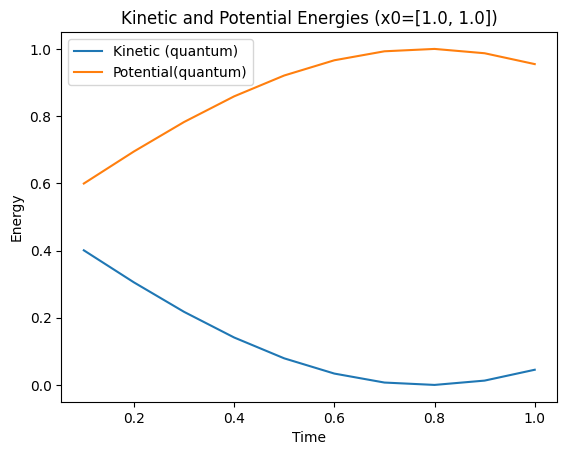

In [11]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots()

ax.plot(t_axis, ks, label="Kinetic (quantum)")
ax.plot(t_axis, ps, label="Potential(quantum)")
# ax.plot(t_axis, pas, label="Potential (analytical)")
ax.set_xlabel("Time")
ax.set_ylabel("Energy")
ax.legend()

ax.set_title(f"Kinetic and Potential Energies (x0={x0})")
plt.show()

In [ ]:
amps = [ps.amplitude for ps in res.result()[0].value.parsed_state_vector if ps["approximator"] == 0 and ps["ancilla"] == 0]
Nsq = sum(Cs)
total_prob = (amps[0]*amps[0].conjugate() + amps[1] * amps[1].conjugate())
Xt = np.sqrt((amps[0]*amps[0].conjugate() / total_prob).real)
Xt*np.sqrt(Nsq)

In [ ]:
analytical = np.cos(t) + np.sin(t)
quantum = (np.sqrt(complex(sv["0000"])*1j) + np.sqrt(complex(sv["0001"])*1j)).real
print(f"Analytical: {analytical:.4f}; Quantum: {quantum:.4f}")

In [ ]:
np.cos(3 * np.pi / 8) + np.sin(3 * np.pi / 8)

In [141]:
t = 2 * np.pi / 3
@qfunc
def main(phi: Output[QBit]):
    allocate(1, phi)
    H(phi)
    RY(2*t, phi)

In [ ]:
backend_preferences = ClassiqBackendPreferences(
    backend_name=ClassiqSimulatorBackendNames.SIMULATOR_STATEVECTOR
)
quantum_model = create_model(main,
    execution_preferences=ExecutionPreferences(
        num_shots=1024, backend_preferences=backend_preferences
    )
)
quantum_program = synthesize(quantum_model)
res = execute(quantum_program)
analytical = np.cos(t) + np.sin(t)
amps = np.array([ps.amplitude for ps in res.result()[0].value.parsed_state_vector]) * norm([1.0, 1.0])
print(f"Analytical={analytical}; Quantum amps={amps}")
print(complex(res.result()[0].value.state_vector["1"]) * norm([1.0, 1.0]))
